<a href="https://colab.research.google.com/github/stonefeld/tpe_nlp_2025/blob/master/experimentos_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Procesamiento del Lenguaje Natural
## Reconocimiento de titulares _clickbait_

## Preparando el entorno

Primero importamos las librerías necesarias para poder correr todos los comandos siguientes para demostrar el funcionamiento de los experimentos planteados para el análisis del trabajo de **Reconocimiento de titulares _clickbait_**

In [72]:
!pip install -q accelerate gensim matplotlib nltk numpy scipy pandas scikit-learn seaborn torch tqdm transformers

In [115]:
# Para matching con regex
import re

# Para manejo del sistema operativo
import os

# Para descarga de embeddings
import urllib.request

# Para descomprimir los embeddings
import zipfile

# Colección para acumular como contador
from collections import Counter

# Manejo de datasets, gráficos y funciones matemáticas
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Para el preprocesamiento
import nltk
from nltk import bigrams, pos_tag, word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

# Vectorizadores, regresión logística y utilidades para métricas
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, train_test_split

# Barras de progreso
from tqdm import tqdm

# Utilitarios para trabajar con GloVe
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

# Redes neuronales complejas y Bert
import torch
from torch.utils.data import Dataset
from transformers import BertForSequenceClassification, BertTokenizer, Trainer, TrainingArguments

Ahora procedemos a instalar los paquetes para el preprocesamiento:

* `stopwords`: corpus de palabras vacías en varios idiomas
* `wordnet`: base de datos de sinónimos y relaciones semánticas
* `omw`: versión traducida y extendida de `wordnet`
* `averaged_perceptron_tagger_eng`: modelo entrenado para etiquetar la categoría gramatical de cada palabra

In [74]:
nltk.download("stopwords", raise_on_error=True)
nltk.download("wordnet", raise_on_error=True)
nltk.download("omw-1.4", raise_on_error=True)
nltk.download("averaged_perceptron_tagger_eng", raise_on_error=True)
nltk.download("punkt_tab", raise_on_error=True)
print("Todos los paquetes se instalaron con éxito")

Todos los paquetes se instalaron con éxito


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Ahora vamos a leer nuestro corpus del dataset de clickbait bajado desde [Kaggle: Clickbait Dataset](https://www.kaggle.com/datasets/amananandrai/clickbait-dataset)

In [75]:
df = pd.read_csv("assets/clickbait_data.csv")
df = df.dropna(subset=["headline", "clickbait"])

In [76]:
print("Shape:", df.shape)
df.head()

Shape: (32000, 2)


,headline,clickbait
0,Should I Get Bings,1
1,Which TV Female Friend Group Do You Belong In,1
2,"The New ""Star Wars: The Force Awakens"" Trailer...",1
3,"This Vine Of New York On ""Celebrity Big Brothe...",1
4,A Couple Did A Stunning Photo Shoot With Their...,1


Vamos a preprocesar el dataset eliminando _stopwords_ y aplicando lematización:

In [77]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(tag):
    if tag.startswith("J"):
        return wordnet.ADJ
    if tag.startswith("V"):
        return wordnet.VERB
    if tag.startswith("N"):
        return wordnet.NOUN
    if tag.startswith("R"):
        return wordnet.ADV
    return wordnet.NOUN

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)
    tokens = word_tokenize(text)
    tagged = pos_tag(tokens)
    lemmas = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in tagged]
    return " ".join(lemmas)

In [78]:
df["clean"] = df["headline"].apply(clean_text)

In [79]:
print("Shape:", df.shape)
df.head()

Shape: (32000, 3)


,headline,clickbait,clean
0,Should I Get Bings,1,should i get bings
1,Which TV Female Friend Group Do You Belong In,1,which tv female friend group do you belong in
2,"The New ""Star Wars: The Force Awakens"" Trailer...",1,the new star war the force awaken trailer be h...
3,"This Vine Of New York On ""Celebrity Big Brothe...",1,this vine of new york on celebrity big brother...
4,A Couple Did A Stunning Photo Shoot With Their...,1,a couple do a stunning photo shoot with their ...


Ahora que ya normalizamos el texto, vamos a dividir los datos en sets de _train_, _valid_ y _test_. Vamos a hacer la siguiente distribución:

* 70% _train_
* 15% _valid_
* 15% _test_

In [80]:
x_train, x_temp, y_train, y_temp = train_test_split(df["clean"], df["clickbait"], test_size=0.3, random_state=42, stratify=df["clickbait"])
x_valid, x_test, y_valid, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
print(f"Train: {len(x_train)}, Valid: {len(x_valid)}, Test: {len(x_test)}")

Train: 22400, Valid: 4800, Test: 4800


## Experimento 1

In [81]:
max_features = 1000
ngram_range = (1, 2)
vectorizer_bow = CountVectorizer(max_features=max_features, ngram_range=ngram_range)
vectorizer_tfidf = TfidfVectorizer(max_features=max_features, ngram_range=ngram_range)
param_grid = {"C": [0.01, 0.1, 1, 10, 100]}
results_exp1 = {}

Mejor C: 1
              precision    recall  f1-score   support

           0    0.94322   0.96208   0.95256      2400
           1    0.96131   0.94208   0.95160      2400

    accuracy                        0.95208      4800
   macro avg    0.95226   0.95208   0.95208      4800
weighted avg    0.95226   0.95208   0.95208      4800



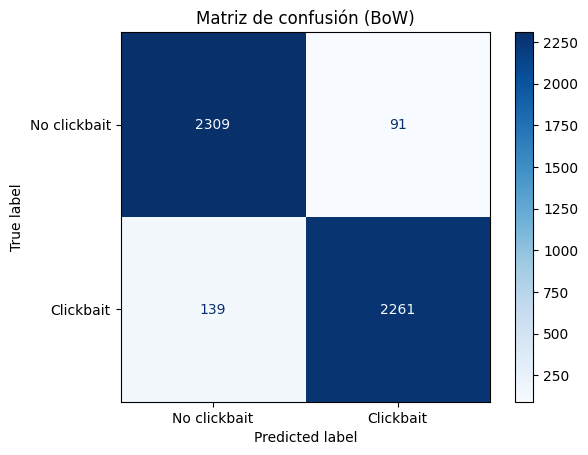

In [82]:
x_train_vec = vectorizer_bow.fit_transform(x_train)
x_valid_vec = vectorizer_bow.transform(x_valid)
x_test_vec = vectorizer_bow.transform(x_test)

log_reg = LogisticRegression(max_iter=1000, solver="liblinear")
grid_bow = GridSearchCV(log_reg, param_grid, cv=3, scoring="f1", n_jobs=-1)
grid_bow.fit(x_train_vec, y_train)

best_log_reg_bow = grid_bow.best_estimator_
print(f"Mejor C: {grid_bow.best_params_['C']}")

y_pred = best_log_reg_bow.predict(x_valid_vec)
report = classification_report(y_valid, y_pred, output_dict=True)
results_exp1["BoW"] = report
print(classification_report(y_valid, y_pred, digits=5))

cm = confusion_matrix(y_valid, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No clickbait", "Clickbait"])
disp.plot(cmap="Blues")
plt.title("Matriz de confusión (BoW)")
plt.show()

Mejor C: 10
              precision    recall  f1-score   support

           0    0.95298   0.95417   0.95357      2400
           1    0.95411   0.95292   0.95351      2400

    accuracy                        0.95354      4800
   macro avg    0.95354   0.95354   0.95354      4800
weighted avg    0.95354   0.95354   0.95354      4800



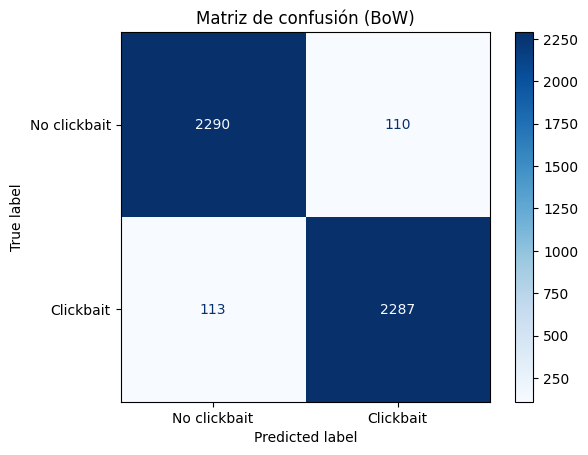

In [83]:
x_train_vec = vectorizer_tfidf.fit_transform(x_train)
x_valid_vec = vectorizer_tfidf.transform(x_valid)
x_test_vec = vectorizer_tfidf.transform(x_test)

log_reg = LogisticRegression(max_iter=1000, solver="liblinear")
grid_tfidf = GridSearchCV(log_reg, param_grid, cv=3, scoring="f1", n_jobs=-1)
grid_tfidf.fit(x_train_vec, y_train)

best_log_reg_tfidf = grid_tfidf.best_estimator_
print(f"Mejor C: {grid_tfidf.best_params_['C']}")

y_pred = best_log_reg_tfidf.predict(x_valid_vec)
report = classification_report(y_valid, y_pred, output_dict=True)
results_exp1["TF-IDF"] = report
print(classification_report(y_valid, y_pred, digits=5))

cm = confusion_matrix(y_valid, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No clickbait", "Clickbait"])
disp.plot(cmap="Blues")
plt.title("Matriz de confusión (BoW)")
plt.show()

In [84]:
df_results = pd.DataFrame(
    {
        name: {
            "Precision": results_exp1[name]["weighted avg"]["precision"],
            "Recall": results_exp1[name]["weighted avg"]["recall"],
            "F1-Score": results_exp1[name]["weighted avg"]["f1-score"],
            "Accuracy": results_exp1[name]["accuracy"],
        }
        for name in results_exp1
    }
).T

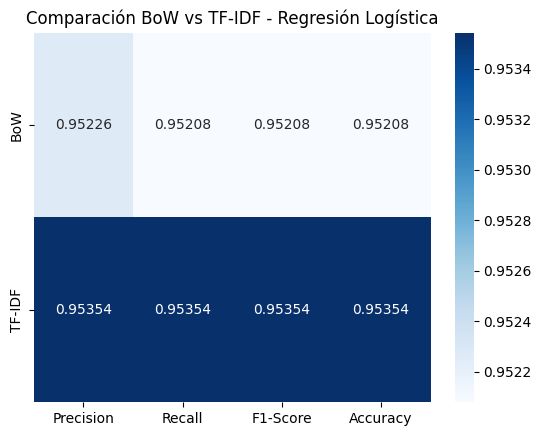

In [85]:
sns.heatmap(df_results, annot=True, fmt=".5f", cmap="Blues")
plt.title("Comparación BoW vs TF-IDF - Regresión Logística")
plt.show()

## Experimento 2

### Usando embeddings GloVe

Primero definimos algunas funciones para descargar y cargar los embeddings de GloVe

In [86]:
def download_glove_embeddings(glove_dir="embeddings", dim=100):
    def remove_file(file_path):
        try:
            os.remove(file_path)
        except Exception:
            pass

    os.makedirs(glove_dir, exist_ok=True)
    glove_file = f"glove.6B.{dim}d.txt"
    glove_path = os.path.join(glove_dir, glove_file)

    if os.path.exists(glove_path):
        file_size = os.path.getsize(glove_path)
        if file_size > 1000:
            print(f"Embeddings GloVe ya existen: {glove_path} ({file_size / 1024 / 1024:.1f} MB)")
            return glove_path
        else:
            print(f"Embeddings GloVe corruptos ({file_size} bytes).")
            remove_file(glove_path)

    print(f"Descargando embeddings GloVe ({dim} dimensiones)...")
    url = "https://nlp.stanford.edu/data/glove.6B.zip"
    zip_path = os.path.join(glove_dir, "glove_6B.zip")

    try:
        def progress_hook(count, block_size, total_size):
            if total_size > 0:
                percent = min(int(count * block_size * 100 / total_size), 100)
                download_mb = count * block_size / (1024 * 1024)
                total_mb = total_size / (1024 * 1024)
                print(f"Descargando... {percent}% ({download_mb:.1f}/{total_mb:.1f} MB)", end="\r")

        urllib.request.urlretrieve(url, zip_path, progress_hook)
        print("Descarga completa. Extrayendo...")

        if not os.path.exists(zip_path) or os.path.getsize(zip_path) < 1000:
            raise Exception("El archivo descargado parece estar corrputo o vacío")

        with zipfile.ZipFile(zip_path, "r") as zip_ref:
            if glove_file not in zip_ref.namelist():
                raise Exception(f"Archivo {glove_file} no encontrando en el ZIP")
            zip_ref.extract(glove_file, glove_dir)

        if not os.path.exists(glove_path) or os.path.getsize(glove_path) < 1000:
            raise Exception("El archivo extraído parece estar corrupto o vacío")

        remove_file(zip_path)
        return glove_path

    except Exception as e:
        print(f"Error descargando embeddings GloVe: {e}")
        remove_file(zip_path)
        return None

In [87]:
def load_glove_model(glove_path, dim=100):
    print(f"Cargando embeddings GloVe desde {glove_path}...")
    try:
        model = KeyedVectors.load_word2vec_format(glove_path, binary=False, no_header=True)
        print(f"GloVe cargado: {len(model)} palabras, {model.vector_size} dimensiones")
        return model

    except Exception as e:
        try:
            print(f"Error al cargar GloVe de manera directa: {e}")
            print("Intentando conversión a Word2Vec...")
            word2vec_path = glove_path.replace(".txt", ".word2vec")

            if not os.path.exists(word2vec_path):
                glove2word2vec(glove_path, word2vec_path)

            model = KeyedVectors.load_word2vec_format(word2vec_path, binary=False)
            print(f"GloVe cargado: {len(model)} palabras, {model.vector_size} dimensiones")
            return model

        except Exception as e:
            print(f"Error al cargar GloVe: {e}")
            return None

In [88]:
def create_document_embeddings(texts, glove_model, dim=100):
    if glove_model is None:
        raise ValueError("glove_model no puede ser None")

    embeddings = []
    words_found = 0
    words_not_found = 0

    for text in tqdm(texts, desc="Creando embeddings GloVe"):
        if not isinstance(text, str):
            text = str(text)

        words = text.split()
        word_embeddings = []

        for word in words:
            if word in glove_model:
                word_embeddings.append(glove_model[word])
                words_found += 1
            else:
                words_not_found += 1

        if word_embeddings:
            doc_embedding = np.mean(word_embeddings, axis=0)
        else:
            doc_embedding = np.zeros(dim)

        embeddings.append(doc_embedding)

    total_words = words_found + words_not_found
    if total_words > 0:
        coverage = words_found / total_words * 100
        print(f"Cobertura de vocabulario: {coverage:.1f}% ({words_found}/{total_words} palabras encontradas)")

    return np.array(embeddings)

Descargamos los embeddings GloVe y creamos el modelo

In [89]:
glove_path = download_glove_embeddings(dim=100)
glove_model = load_glove_model(glove_path, dim=100)

Embeddings GloVe ya existen: embeddings/glove.6B.100d.txt (331.0 MB)
Cargando embeddings GloVe desde embeddings/glove.6B.100d.txt...
GloVe cargado: 400000 palabras, 100 dimensiones


Creamos los embeddings en base a nuestros titulares

In [90]:
x_train_glove = create_document_embeddings(x_train, glove_model, dim=100)
x_valid_glove = create_document_embeddings(x_valid, glove_model, dim=100)
x_test_glove = create_document_embeddings(x_test, glove_model, dim=100)

print("Embeddings creados:")
print(f"Train: {x_train_glove.shape}")
print(f"Valid: {x_valid_glove.shape}")
print(f"Test: {x_test_glove.shape}")

Creando embeddings GloVe: 100%|██████████| 22400/22400 [00:01<00:00, 13891.18it/s]


Cobertura de vocabulario: 98.7% (193652/196208 palabras encontradas)


Creando embeddings GloVe: 100%|██████████| 4800/4800 [00:00<00:00, 19224.90it/s]


Cobertura de vocabulario: 98.7% (41329/41885 palabras encontradas)


Creando embeddings GloVe: 100%|██████████| 4800/4800 [00:00<00:00, 17394.26it/s]

Cobertura de vocabulario: 98.5% (41030/41641 palabras encontradas)
Embeddings creados:
Train: (22400, 100)
Valid: (4800, 100)
Test: (4800, 100)


Ahora entrenamos al modelo

In [91]:
param_grid = {"C": [0.01, 0.1, 1, 10, 100]}
log_reg = LogisticRegression(max_iter=1000, solver="liblinear", random_state=42)
grid_glove = GridSearchCV(log_reg, param_grid, cv=3, scoring="f1", n_jobs=-1)
grid_glove.fit(x_train_glove, y_train)

print(f"Mejor C: {grid_glove.best_params_['C']}")

Mejor C: 100


Ahora evaluamos en validación para verificar

              precision    recall  f1-score   support

           0    0.93818   0.93583   0.93700      2400
           1    0.93599   0.93833   0.93716      2400

    accuracy                        0.93708      4800
   macro avg    0.93709   0.93708   0.93708      4800
weighted avg    0.93709   0.93708   0.93708      4800



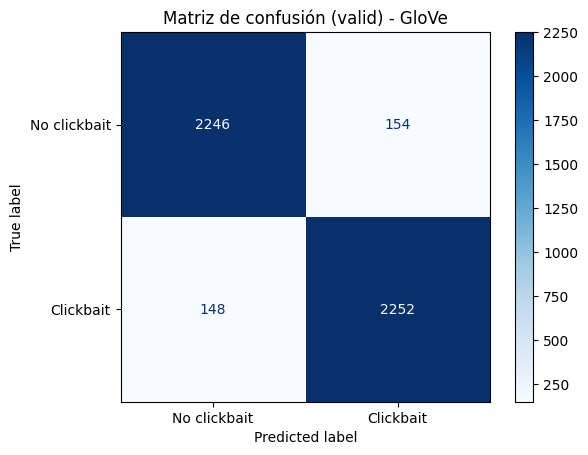

In [92]:
y_pred = grid_glove.predict(x_valid_glove)
print(classification_report(y_valid, y_pred, digits=5))

cm = confusion_matrix(y_valid, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No clickbait", "Clickbait"])
disp.plot(cmap="Blues")
plt.title("Matriz de confusión (valid) - GloVe")
plt.show()

Ahora evaluamos en test

              precision    recall  f1-score   support

           0    0.94836   0.94125   0.94479      2400
           1    0.94169   0.94875   0.94521      2400

    accuracy                        0.94500      4800
   macro avg    0.94503   0.94500   0.94500      4800
weighted avg    0.94503   0.94500   0.94500      4800



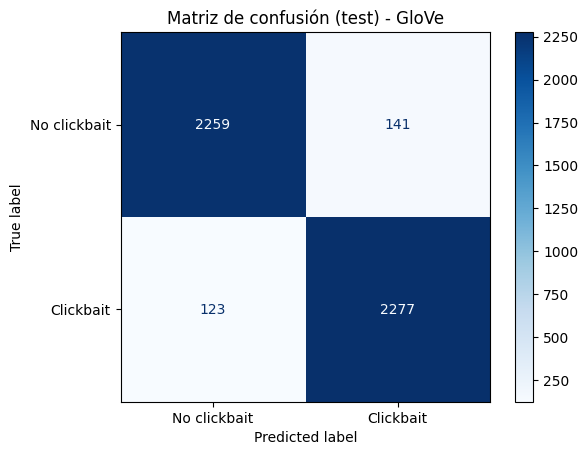

In [94]:
y_pred = grid_glove.predict(x_test_glove)
print(classification_report(y_test, y_pred, digits=5))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No clickbait", "Clickbait"])
disp.plot(cmap="Blues")
plt.title("Matriz de confusión (test) - GloVe")
plt.show()

### Usando Bert como Language Model

In [ ]:
class ClickbaitDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx] if hasattr(self.texts, "iloc") else self.texts[idx])
        label = int(self.labels.iloc[idx] if hasattr(self.labels, "iloc") else self.labels[idx])

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt",
        )

        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "labels": torch.tensor(label, dtype=torch.long),
        }

In [ ]:
def fine_tune_bert(X_train, y_train, X_valid, y_valid, num_epochs=3, batch_size=16, learning_rate=2e-5, max_length=128):
    try:
        print("Cargando modelo BERT para fine-tuning...")
        tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
        model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)
        print(f"BERT cargado en {device}")

        print("Preparando datasets...")
        train_dataset = ClickbaitDataset(X_train, y_train, tokenizer, max_length=max_length)
        valid_dataset = ClickbaitDataset(X_valid, y_valid, tokenizer, max_length=max_length)

        training_args = TrainingArguments(
            output_dir="./bert_clickbait_model",
            num_train_epochs=num_epochs,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            learning_rate=learning_rate,
            weight_decay=0.01,
            logging_dir="./logs",
            logging_steps=50,  # Menos logging para más velocidad
            eval_strategy="epoch",
            save_strategy="epoch",
            load_best_model_at_end=True,
            metric_for_best_model="f1",
            greater_is_better=True,
            save_total_limit=2,
            report_to="none",  # No usar wandb/tensorboard
            # fp16=torch.cuda.is_available(),  # Mixed precision solo si hay GPU
            dataloader_num_workers=2 if torch.cuda.is_available() else 0,  # Paralelismo solo con GPU
            # gradient_accumulation_steps=2,  # Acumular gradientes para simular batch 2x más grande
            # warmup_steps=100,  # Warmup más corto
            # max_steps=-1,  # Usar epochs en lugar de steps
        )

        def compute_metrics(eval_pred):
            predictions, labels = eval_pred
            predictions = np.argmax(predictions, axis=1)
            return {
                "accuracy": accuracy_score(labels, predictions),
                "f1": f1_score(labels, predictions, average="weighted", zero_division=0),
                "precision": precision_score(labels, predictions, average="weighted", zero_division=0),
                "recall": recall_score(labels, predictions, average="weighted", zero_division=0),
            }

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=valid_dataset,
            compute_metrics=compute_metrics,
        )

        print(f"\nIniciando fine-tuning de BERT...")
        print(f"   Épocas: {num_epochs}")
        print(f"   Batch size: {batch_size}")
        print(f"   Max length: {max_length}")
        print(f"   Learning rate: {learning_rate}")
        print(f"   Dispositivo: {device}")

        trainer.train()

        print("\nFine-tuning completado!")

        print("\nEvaluando en conjunto de validación...")
        eval_results = trainer.evaluate()
        print(f"   Accuracy (Valid): {eval_results['eval_accuracy']:.4f}")
        print(f"   F1-Score (Valid): {eval_results['eval_f1']:.4f}")
        print(f"   Precision (Valid): {eval_results['eval_precision']:.4f}")
        print(f"   Recall (Valid): {eval_results['eval_recall']:.4f}")

        return model, tokenizer

    except RuntimeError as e:
        if "out of memory" in str(e):
            print(f"Error de memoria durante fine-tuning: {e}")
        else:
            print(f"Error de runtime durante fine-tuning: {e}")
        return None, None

    except Exception as e:
        print(f"Error durante fine-tuning: {e}")
        return None, None

In [ ]:
def predict_with_bert(model, tokenizer, texts, batch_size=32, max_length=128):
    if model is None or tokenizer is None:
        return None

    device = next(model.parameters()).device
    model.eval()

    predictions = []

    with torch.no_grad():
        for i in tqdm(range(0, len(texts), batch_size), desc="Prediciendo con BERT"):
            batch_texts = texts[i : i + batch_size]
            batch_texts = [str(text) for text in batch_texts]

            inputs = tokenizer(
                batch_texts,
                padding=True,
                truncation=True,
                max_length=max_length,
                return_tensors="pt",
            )

            inputs = {k: v.to(device) for k, v in inputs.items()}

            outputs = model(**inputs)
            logits = outputs.logits
            batch_predictions = torch.argmax(logits, dim=-1).cpu().numpy()
            predictions.extend(batch_predictions)

    return np.array(predictions)

In [ ]:
batch_size = 32
max_length = 128
bert_model, bert_tokenizer = fine_tune_bert(
    x_train, y_train, x_valid, y_valid,
    num_epochs=3,
    batch_size=batch_size,
    learning_rate=2e-5,
    max_length=max_length
)


In [ ]:
y_pred = predict_with_bert(bert_model, bert_tokenizer, x_test, batch_size=batch_size * 2, max_length=max_length)
print(classification_report(y_test, y_pred, digits=5))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No clickbait", "Clickbait"])
disp.plot(cmap="Blues")
plt.title("Matriz de confusión (test) - BERT")
plt.show()

## Experimento 3

In [95]:
def analyze_linguistic_patterns(texts, labels):
    patterns = {
        "question_words": ["what", "how", "why", "when", "where", "which", "who", "whom", "whose"],
        "imperative_words": ["must", "should", "need", "have to", "got to", "gotta", "will", "won't"],
        "emotional_words": [
            "amazing", "shocking", "incredible", "unbelievable", "stunning", "wow", "mind-blowing",
            "you won't believe", "secret", "hidden", "revealed", "shocking truth", "exposed",
        ],
        "number_words": ["one", "two", "three", "four", "five", "ten", "hundred", "thousand", "million"],
        "personal_pronouns": ["you", "your", "yours", "yourself", "yourselves"],
        "urgency_words": ["now", "today", "this instant", "immediately", "urgent", "breaking"],
        "superlatives": ["best", "worst", "biggest", "smallest", "most", "least", "first", "last"],
    }

    results = {}

    for pattern_name, pattern_words in patterns.items():
        clickbait_count = 0
        non_clickbait_count = 0
        clickbait_examples = []
        non_clickbait_examples = []

        for text, label in zip(texts, labels):
            text_lower = str(text).lower()
            # Verificar si alguna palabra/frase del patrón está en el texto
            has_pattern = False
            for pattern in pattern_words:
                # Para frases (con espacios), buscar la frase completa
                if " " in pattern:
                    if pattern in text_lower:
                        has_pattern = True
                        break
                else:
                    # Para palabras, buscar la palabra en el texto
                    # Usar regex para buscar como palabra completa (evitar subcadenas)
                    if re.search(r'\b' + re.escape(pattern) + r'\b', text_lower):
                        has_pattern = True
                        break

            if has_pattern:
                if label == 1:
                    clickbait_count += 1
                    if len(clickbait_examples) < 3:
                        clickbait_examples.append(text)
                else:
                    non_clickbait_count += 1
                    if len(non_clickbait_examples) < 3:
                        non_clickbait_examples.append(text)

        total = clickbait_count + non_clickbait_count
        results[pattern_name] = {
            "clickbait": clickbait_count,
            "non_clickbait": non_clickbait_count,
            "total": total,
            "clickbait_examples": clickbait_examples,
            "non_clickbait_examples": non_clickbait_examples,
        }

    return results

In [96]:
def get_top_words_by_class(texts, labels, n=20):
    clickbait_texts = [str(text).lower() for text, label in zip(texts, labels) if label == 1]
    non_clickbait_texts = [str(text).lower() for text, label in zip(texts, labels) if label == 0]

    def tokenize_and_count(text_list):
        all_words = []
        for text in text_list:
            words = word_tokenize(text)
            words = [w for w in words if w.isalpha() and w not in stop_words]
            all_words.extend(words)
        return Counter(all_words)

    clickbait_counter = tokenize_and_count(clickbait_texts)
    non_clickbait_counter = tokenize_and_count(non_clickbait_texts)

    top_clickbait = clickbait_counter.most_common(n)
    top_non_clickbait = non_clickbait_counter.most_common(n)

    return top_clickbait, top_non_clickbait

In [97]:
def get_top_bigrams_by_class(texts, labels, n=15):
    clickbait_texts = [str(text).lower() for text, label in zip(texts, labels) if label == 1]
    non_clickbait_texts = [str(text).lower() for text, label in zip(texts, labels) if label == 0]

    def get_bigrams(text_list):
        all_bigrams = []
        for text in text_list:
            words = word_tokenize(text)
            words = [w for w in words if w.isalpha() and w not in stop_words]
            bigram_list = list(bigrams(words))
            all_bigrams.extend(bigram_list)
        return Counter(all_bigrams)

    clickbait_bigrams = get_bigrams(clickbait_texts)
    non_clickbait_bigrams = get_bigrams(non_clickbait_texts)

    top_clickbait = clickbait_bigrams.most_common(n)
    top_non_clickbait = non_clickbait_bigrams.most_common(n)

    return top_clickbait, top_non_clickbait

In [98]:
feature_names = vectorizer_tfidf.get_feature_names_out()
coefficients = best_log_reg_tfidf.coef_[0]
feature_importance = pd.DataFrame(
    {
        "feature": feature_names,
        "coefficient": coefficients,
    }
).sort_values("coefficient", ascending=False)

In [99]:
top_clickbait_features = feature_importance.head(20)
top_non_clickbait_features = feature_importance.tail(20).sort_values("coefficient")

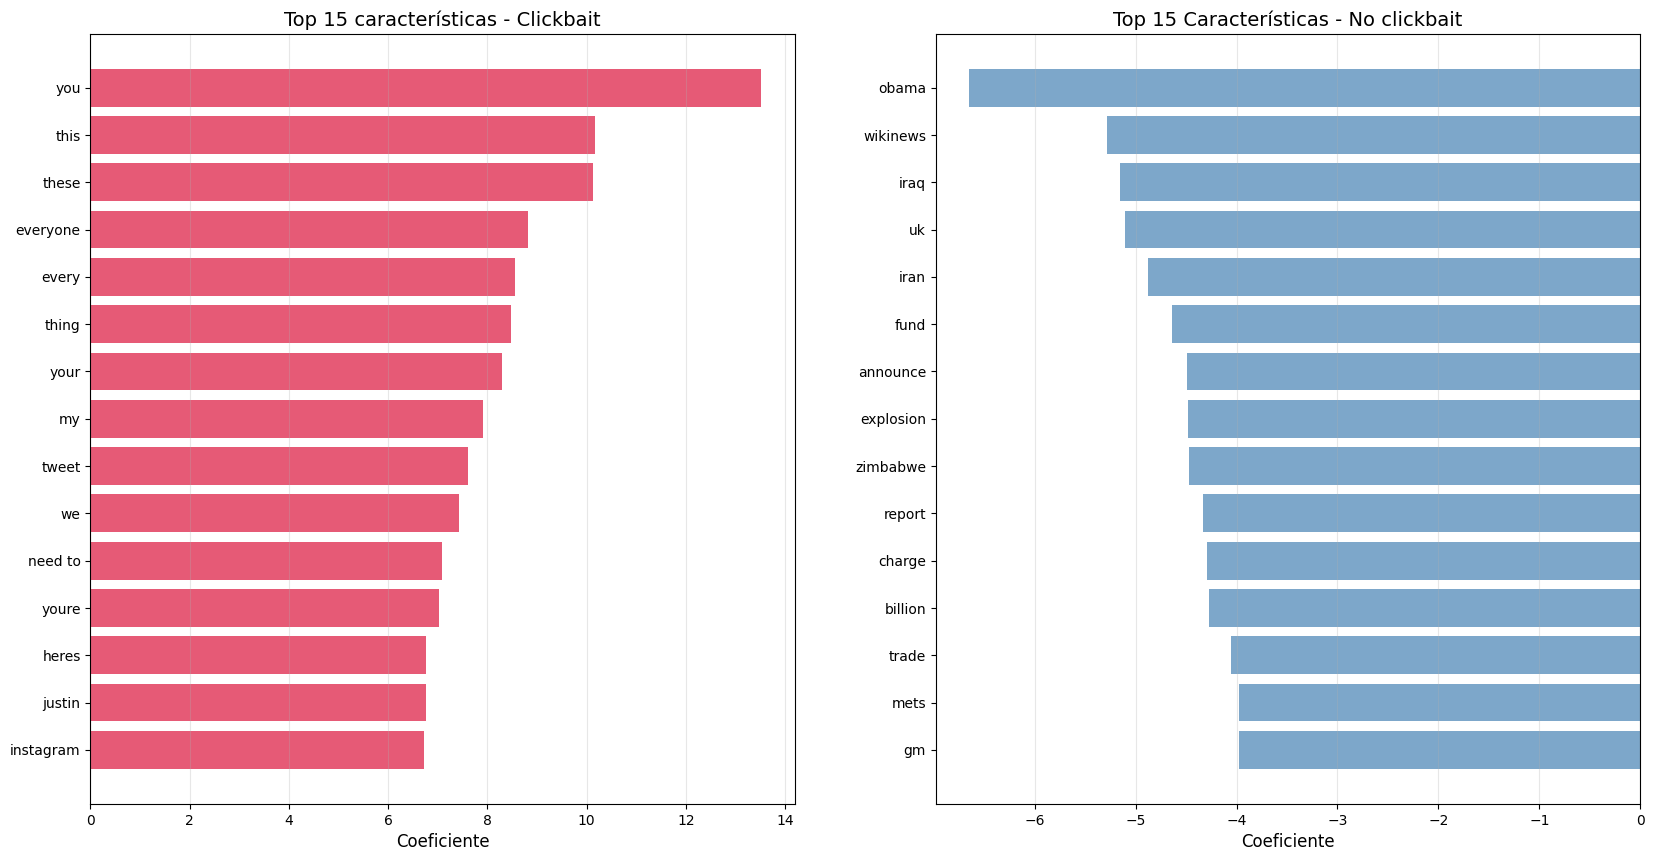

In [127]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

top_clickbait_plot = top_clickbait_features.head(15)
ax1.barh(range(len(top_clickbait_plot)), top_clickbait_plot["coefficient"], color="crimson", alpha=0.7)
ax1.set_yticks(range(len(top_clickbait_plot)))
ax1.set_yticklabels(top_clickbait_plot["feature"], fontsize=10)
ax1.set_xlabel("Coeficiente", fontsize=12)
ax1.set_title("Top 15 características - Clickbait", fontsize=14)
ax1.invert_yaxis()
ax1.grid(True, alpha=0.3, axis="x")

top_non_clickbait_plot = top_non_clickbait_features.head(15)
ax2.barh(range(len(top_non_clickbait_plot)), top_non_clickbait_plot["coefficient"], color="steelblue", alpha=0.7)
ax2.set_yticks(range(len(top_non_clickbait_plot)))
ax2.set_yticklabels(top_non_clickbait_plot["feature"], fontsize=10)
ax2.set_xlabel("Coeficiente", fontsize=12)
ax2.set_title("Top 15 Características - No clickbait", fontsize=14)
ax2.invert_yaxis()
ax2.grid(True, alpha=0.3, axis="x")

plt.show()

In [103]:
pattern_results = analyze_linguistic_patterns(df["headline"], df["clickbait"])

In [104]:
pattern_summary = []
for pattern_name, counts in pattern_results.items():
    total = counts["total"]
    if total > 0:
        cb_ratio = counts["clickbait"] / total * 100
        ncb_ratio = counts["non_clickbait"] / total * 100
        pattern_pct = total / len(df) * 100

        pattern_summary.append(
            {
                "Patrón": pattern_name.replace("_", " ").title(),
                "Total": total,
                "% Dataset": f"{pattern_pct:.1f}%",
                "Clickbait": f"{counts['clickbait']} ({cb_ratio:.1f}%)",
                "No Clickbait": f"{counts['non_clickbait']} ({ncb_ratio:.1f}%)",
                "Ratio CB": f"{cb_ratio:.1f}%",
            }
        )

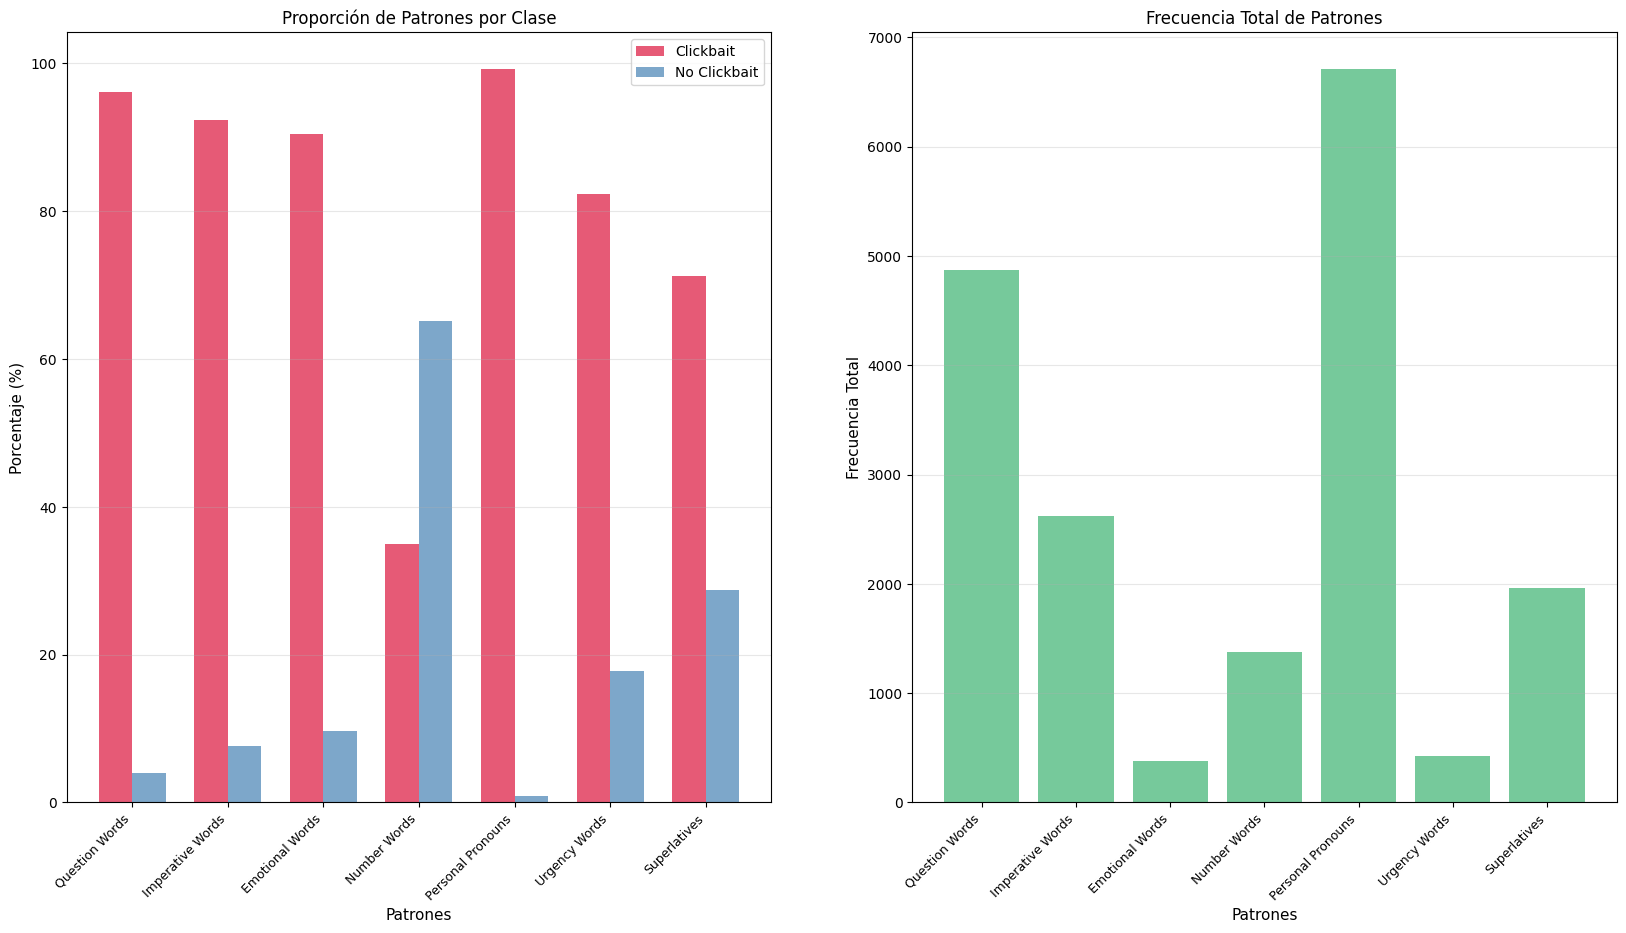

In [112]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

pattern_names = [p.replace("_", " ").title() for p in pattern_results.keys()]
width = 0.35
cb_ratios = [
    pattern_results[p]["clickbait"] / max(pattern_results[p]["total"], 1) * 100
    for p in pattern_results.keys()
]
ncb_ratios = [
    pattern_results[p]["non_clickbait"] / max(pattern_results[p]["total"], 1) * 100
    for p in pattern_results.keys()
]

ax1.bar(x - width / 2, cb_ratios, width, label="Clickbait", color="crimson", alpha=0.7)
ax1.bar(x + width / 2, ncb_ratios, width, label="No Clickbait", color="steelblue", alpha=0.7)
ax1.set_xlabel("Patrones", fontsize=11)
ax1.set_ylabel("Porcentaje (%)", fontsize=11)
ax1.set_title("Proporción de Patrones por Clase", fontsize=12)
ax1.set_xticks(x)
ax1.set_xticklabels(pattern_names, rotation=45, ha="right", fontsize=9)
ax1.legend()
ax1.grid(True, alpha=0.3, axis="y")

total_counts = [pattern_results[p]["total"] for p in pattern_results.keys()]
ax2.bar(range(len(pattern_names)), total_counts, color="mediumseagreen", alpha=0.7)
ax2.set_xlabel("Patrones", fontsize=11)
ax2.set_ylabel("Frecuencia Total", fontsize=11)
ax2.set_title("Frecuencia Total de Patrones", fontsize=12)
ax2.set_xticks(range(len(pattern_names)))
ax2.set_xticklabels(pattern_names, rotation=45, ha="right", fontsize=9)
ax2.grid(True, alpha=0.3, axis="y")

plt.show()

In [117]:
top_clickbait_words, top_non_clickbait_words = get_top_words_by_class(df["headline"], df["clickbait"], n=20)

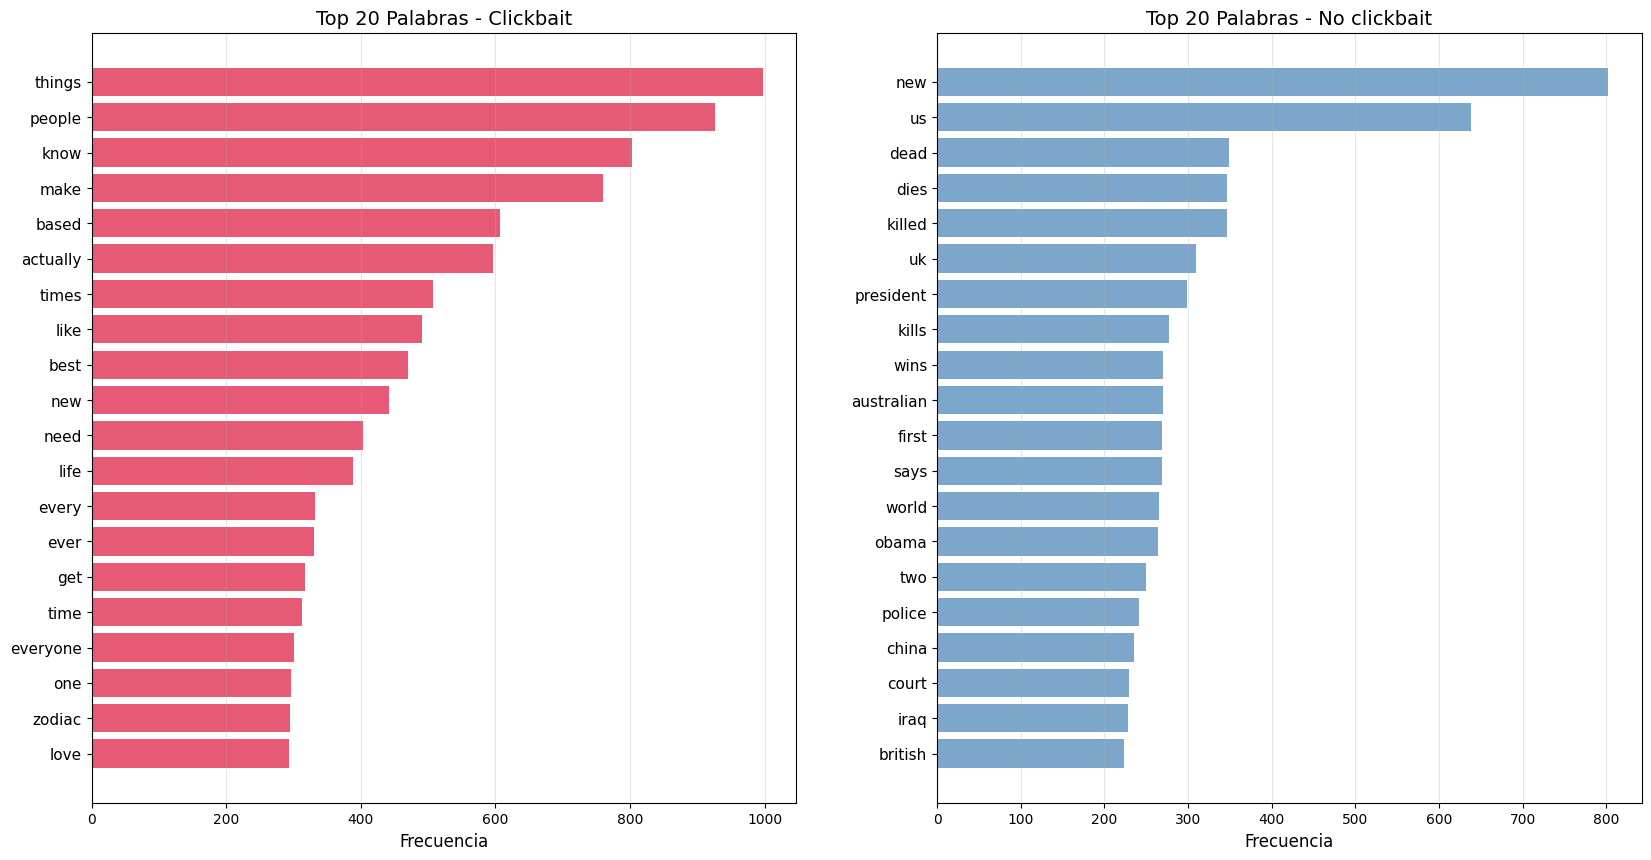

In [128]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

words_cb = [w for w, _ in top_clickbait_words]
counts_cb = [c for _, c in top_clickbait_words]
ax1.barh(range(len(words_cb)), counts_cb, color="crimson", alpha=0.7)
ax1.set_yticks(range(len(words_cb)))
ax1.set_yticklabels(words_cb, fontsize=11)
ax1.set_xlabel("Frecuencia", fontsize=12)
ax1.set_title("Top 20 Palabras - Clickbait", fontsize=14)
ax1.invert_yaxis()
ax1.grid(True, alpha=0.3, axis="x")

words_ncb = [w for w, _ in top_non_clickbait_words]
counts_ncb = [c for _, c in top_non_clickbait_words]
ax2.barh(range(len(words_ncb)), counts_ncb, color="steelblue", alpha=0.7)
ax2.set_yticks(range(len(words_ncb)))
ax2.set_yticklabels(words_ncb, fontsize=11)
ax2.set_xlabel("Frecuencia", fontsize=12)
ax2.set_title("Top 20 Palabras - No clickbait", fontsize=14)
ax2.invert_yaxis()
ax2.grid(True, alpha=0.3, axis="x")

plt.show()

In [119]:
top_clickbait_bigrams, top_non_clickbait_bigrams = get_top_bigrams_by_class(df["headline"], df["clickbait"], n=15)

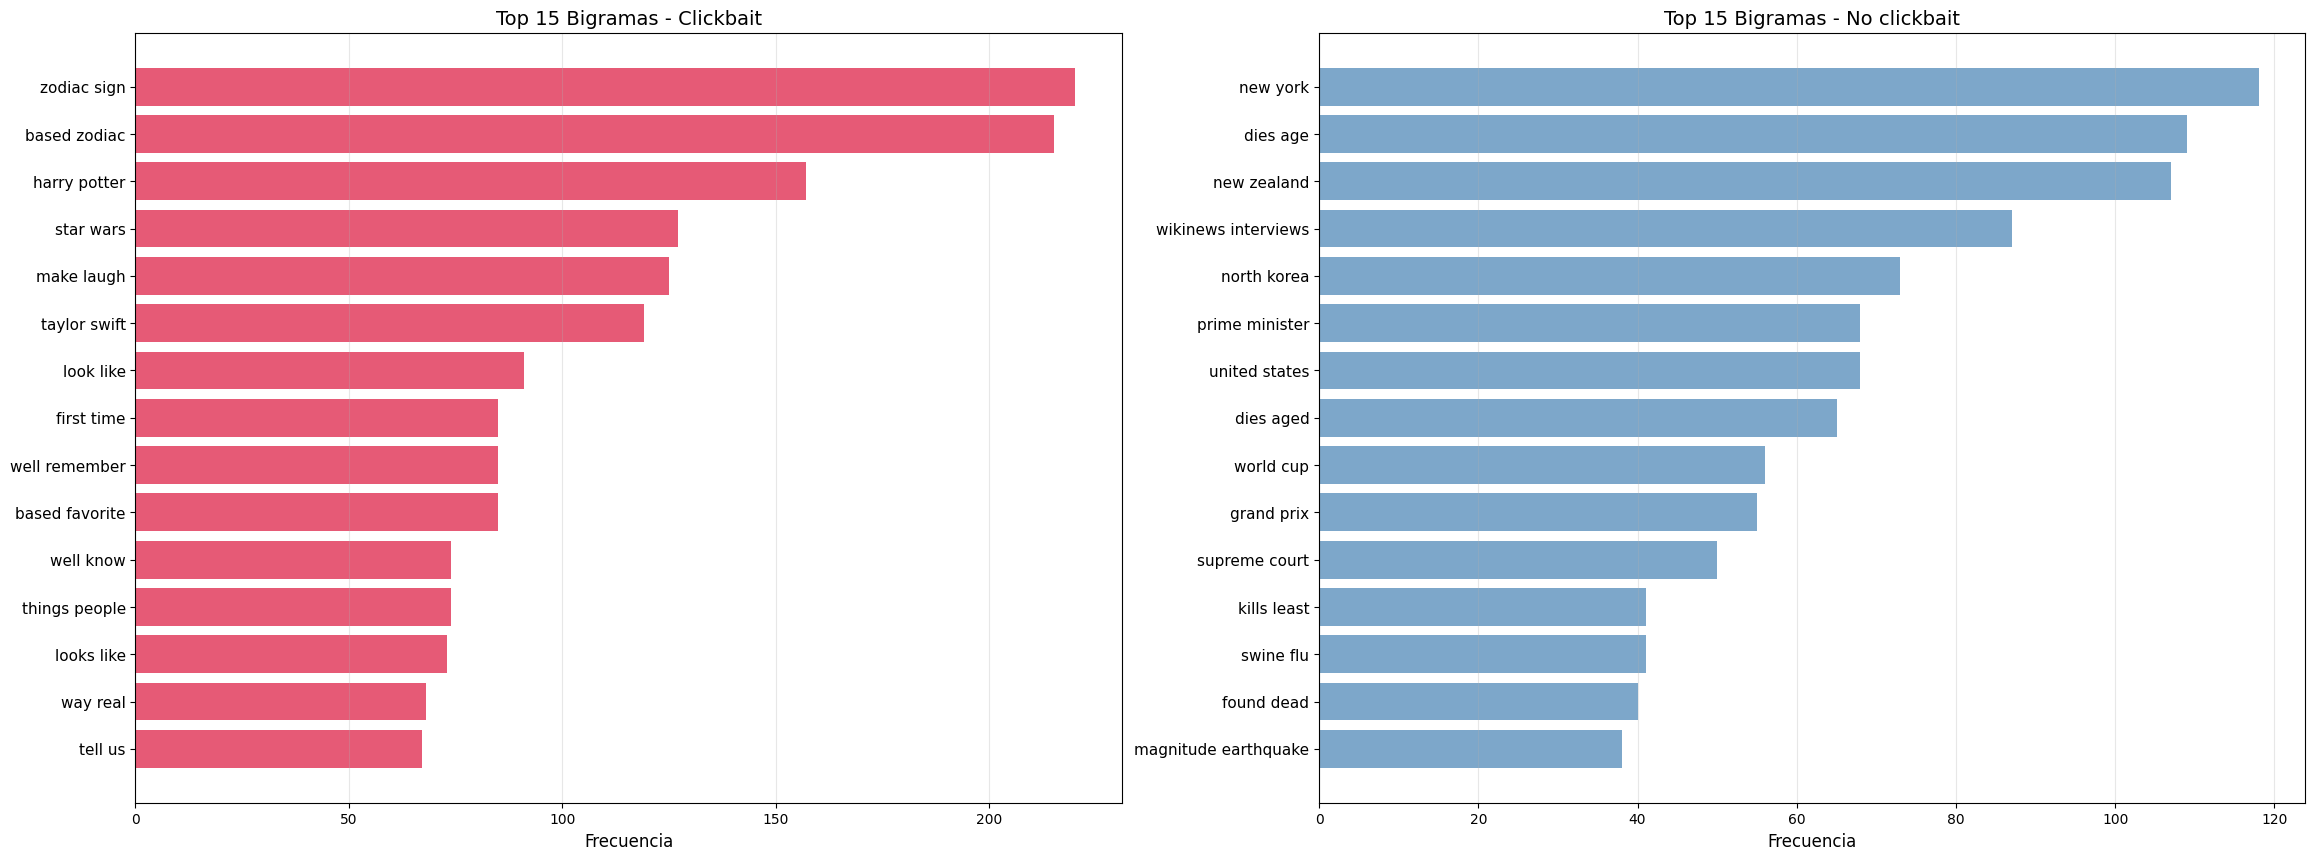

In [129]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(28, 10))

bigrams_cb = [" ".join(bg) for bg, _ in top_clickbait_bigrams]
counts_bg_cb = [c for _, c in top_clickbait_bigrams]
ax1.barh(range(len(bigrams_cb)), counts_bg_cb, color="crimson", alpha=0.7)
ax1.set_yticks(range(len(bigrams_cb)))
ax1.set_yticklabels(bigrams_cb, fontsize=11)
ax1.set_xlabel("Frecuencia", fontsize=12)
ax1.set_title("Top 15 Bigramas - Clickbait", fontsize=14)
ax1.invert_yaxis()
ax1.grid(True, alpha=0.3, axis="x")

bigrams_ncb = [" ".join(bg) for bg, _ in top_non_clickbait_bigrams]
counts_bg_ncb = [c for _, c in top_non_clickbait_bigrams]
ax2.barh(range(len(bigrams_ncb)), counts_bg_ncb, color="steelblue", alpha=0.7)
ax2.set_yticks(range(len(bigrams_ncb)))
ax2.set_yticklabels(bigrams_ncb, fontsize=11)
ax2.set_xlabel("Frecuencia", fontsize=12)
ax2.set_title("Top 15 Bigramas - No clickbait", fontsize=14)
ax2.invert_yaxis()
ax2.grid(True, alpha=0.3, axis="x")

plt.show()

In [130]:
df["num_words"] = df["headline"].apply(lambda x: len(str(x).split()))
df.groupby("clickbait")["num_words"].describe()

,count,mean,std,min,25%,50%,75%,max
clickbait,,,,,,,,
0,16001.0,8.188613,2.224814,2.0,7.0,8.0,9.0,21.0
1,15999.0,9.941809,2.659194,1.0,8.0,10.0,12.0,26.0


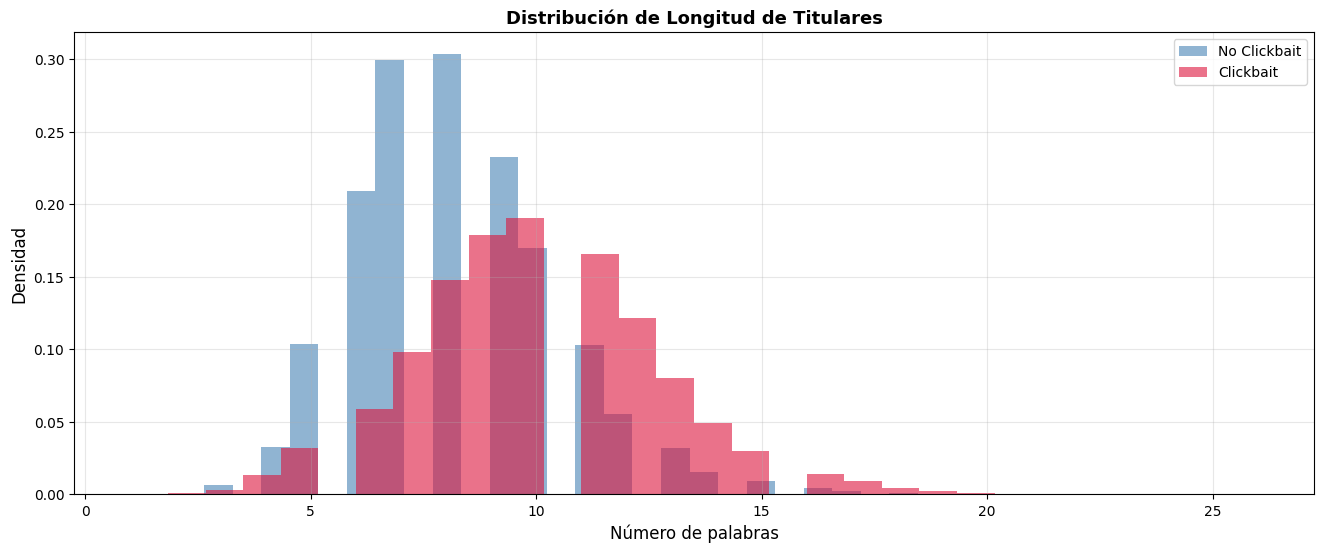

In [133]:
fig, ax = plt.subplots(1, 1, figsize=(16, 6))

ax.hist(
    df[df["clickbait"] == 0]["num_words"],
    bins=30,
    alpha=0.6,
    label="No Clickbait",
    color="steelblue",
    density=True,
)
ax.hist(
    df[df["clickbait"] == 1]["num_words"],
    bins=30,
    alpha=0.6,
    label="Clickbait",
    color="crimson",
    density=True,
)
ax.set_xlabel("Número de palabras", fontsize=12)
ax.set_ylabel("Densidad", fontsize=12)
ax.set_title("Distribución de Longitud de Titulares", fontsize=13, fontweight="bold")
ax.legend()
ax.grid(True, alpha=0.3)